In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


# PacWhitesidedDolphin whale vocalizations
Source:
- https://www.mobysound.org/
- http://localhost:8186/tree/Datasets/mobysound/PacWhitesidedDolphin


In [17]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import librosa

In [18]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter
from avgn_paper.signalprocessing import spectrogramming as sg
import wave

### data locations

In [19]:
DSLOC = Path('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin')

In [20]:
DSLOC

PosixPath('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin')

### load wavs

In [21]:
wavs = list(DSLOC.glob('*.wav'))
len(wavs), wavs[:3]

(4,
 [PosixPath('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/._Lo-070421-164044-Lo-B16h40m44s21apr2007y.wav'),
  PosixPath('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/Lo-070421-164044-Lo-B16h40m44s21apr2007y.wav'),
  PosixPath('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/QX-Lo-FLIP0610-VLA-061018-210000.wav')])

In [27]:
wav_df = pd.DataFrame(columns = ['stem', 'path', 'rate'])
for wav in wavs:
    print(wav)
    try:
        with wave.open(wav.as_posix(), 'rb') as f:
            rate = f.getframerate()
        wav_df.loc[len(wav_df)] = [wav.stem, wav, rate]
    except:
        print('broken')
        continue

/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/._Lo-070421-164044-Lo-B16h40m44s21apr2007y.wav
broken
/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/Lo-070421-164044-Lo-B16h40m44s21apr2007y.wav
/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/QX-Lo-FLIP0610-VLA-061018-210000.wav
/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/QX-Lo-CC0604-TAT08-060406-195843.wav


In [28]:
wav_df

,stem,path,rate
0,Lo-070421-164044-Lo-B16h40m44s21apr2007y,/mnt/cube/Datasets/mobysound/PacWhitesidedDolp...,192000
1,QX-Lo-FLIP0610-VLA-061018-210000,/mnt/cube/Datasets/mobysound/PacWhitesidedDolp...,192000
2,QX-Lo-CC0604-TAT08-060406-195843,/mnt/cube/Datasets/mobysound/PacWhitesidedDolp...,192000


### Load labels

In [39]:
click_types = [
    ['buzzd', '*buzzd.txt'],
    ['buzze', '*buzze.txt'],
    ['buzzf', '*buzzf.txt'],
    ['buzzg', '*buzzg.txt'],
    ['buzzh', '*buzzh.txt'],
    ['buzzd', '*buzzd.txt'],
    ['type 1', '*type 1.txt'],
    ['type 1a', '*type 1a.txt'],
    ['type 1b', '*type 1b.txt'],
    ['type 1c', '*type 1c.txt'],
    ['type 1d', '*type 1d.txt'],
    ['type 1e', '*type 1e.txt'],
    ['type 1f', '*type 1f.txt'],
    ['type 1g', '*type 1g.txt'],
    ['type 1h', '*type 1h.txt'],
    ['type 2', '*type 2.txt'],
    ['type 2b', '*type 2b.txt'],
    #['type 2c', '*type 2c.txt'],
    ['type 2d', '*type 2d.txt'],
    ['type 2e', '*type 2e.txt'],
    ['type 2f', '*type 2f.txt'],
    ['type 2g', '*type 2g.txt'],
    ['type 2h', '*type 2h.txt'],
]

In [46]:
click_label_loc

PosixPath('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/QX-Lo-FLIP0610-VLA-061018-210000.type 2h.txt')

In [48]:
clicks_df = []
for click_type, click_type_glob in click_types:
    good_clicks = list(DSLOC.glob(click_type_glob))
    for click_label_loc in good_clicks:
        try:
            good_clicks_df = pd.read_csv(click_label_loc, delimiter='\t')
        except:
            print(click_label_loc)
            continue
        good_clicks_df['stem'] = click_label_loc.stem
        good_clicks_df['click_value'] = click_type
        clicks_df.append(good_clicks_df)
clicks_df = pd.concat(clicks_df)
clicks_df.columns = [re.sub(' +', ' ', i) for i in clicks_df.columns]

/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/QX-Lo-FLIP0610-VLA-061018-210000.type 2h.txt


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [49]:
len(clicks_df)

14340

In [50]:
clicks_df[:3]

,duration,end time,low freq,high freq,%,% start time,Unnamed: 3,Unnamed: 5,click_value,stem
0,0.45552,349.32522,13743.90244,73566.51885,NaN,348.87,NaN,NaN,buzzd,Lo-070421-164044-Lo-B16h40m44s21apr2007y.buzzd
1,0.37800,350.54606,21958.98004,76515.52106,NaN,350.168,NaN,NaN,buzzd,Lo-070421-164044-Lo-B16h40m44s21apr2007y.buzzd
0,0.45552,349.32522,13743.90244,73566.51885,NaN,348.87,NaN,NaN,buzze,Lo-070421-164044-Lo-B16h40m44s21apr2007y.buzze


In [51]:
clicks_df.columns

Index([' duration', ' end time', ' low freq', ' high freq', '%',
       '% start time', 'Unnamed: 3', 'Unnamed: 5', 'click_value', 'stem'],
      dtype='object')

In [52]:
clicks_df.click_value.unique()

array(['buzzd', 'buzze', 'buzzf', 'buzzg', 'buzzh', 'type 1', 'type 1a',
       'type 1b', 'type 1c', 'type 1d', 'type 1e', 'type 1f', 'type 1g',
       'type 1h', 'type 2', 'type 2b', 'type 2d', 'type 2e', 'type 2f',
       'type 2g', 'type 2h'], dtype=object)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


KeyboardInterrupt: 

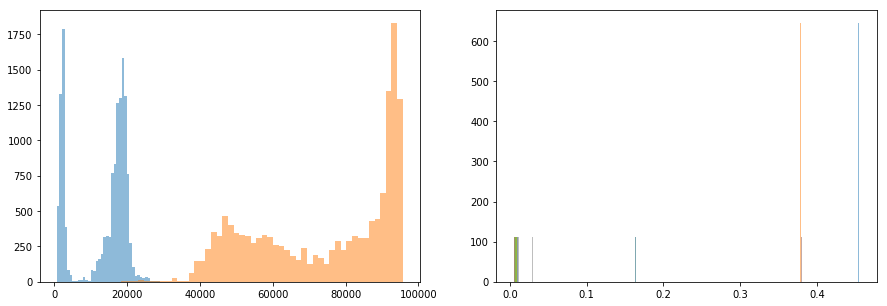

In [53]:
nbins = 50
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0].hist(clicks_df[" low freq"].values, bins=nbins, alpha=0.5, label="low freq")
axs[0].hist(clicks_df[" high freq"].values, bins=nbins, alpha=0.5, label="high freq")

for click_value in clicks_df.click_value.unique():
    axs[1].hist(
        clicks_df[clicks_df.click_value == click_value][" end time"].values
        - clicks_df[clicks_df.click_value == click_value]["% start time"].values,
        bins=nbins, normed = True, label=click_value, alpha = 0.5
    )
axs[0].legend()
axs[1].legend()

### get example click

In [54]:
click_row = clicks_df.iloc[1]

In [81]:
clicks_df[:3]

,duration,end time,low freq,high freq,%,% start time,Unnamed: 3,Unnamed: 5,click_value,stem
0,0.45552,349.32522,13743.90244,73566.51885,NaN,348.87,NaN,NaN,buzzd,Lo-070421-164044-Lo-B16h40m44s21apr2007y.buzzd
1,0.37800,350.54606,21958.98004,76515.52106,NaN,350.168,NaN,NaN,buzzd,Lo-070421-164044-Lo-B16h40m44s21apr2007y.buzzd
0,0.45552,349.32522,13743.90244,73566.51885,NaN,348.87,NaN,NaN,buzze,Lo-070421-164044-Lo-B16h40m44s21apr2007y.buzze


In [55]:
click_row

 duration                                                0.378
 end time                                              350.546
 low freq                                                21959
 high freq                                             76515.5
%                                                          NaN
% start time                                           350.168
Unnamed: 3                                                 NaN
Unnamed: 5                                                 NaN
click_value                                              buzzd
stem            Lo-070421-164044-Lo-B16h40m44s21apr2007y.buzzd
Name: 1, dtype: object

In [58]:
click_row.stem

'Lo-070421-164044-Lo-B16h40m44s21apr2007y.buzzd'

In [59]:
wav_df.stem == '_'.join(click_row.stem.split('.')[:-1])

0     True
1    False
2    False
Name: stem, dtype: bool

In [61]:
??librosa.core.load

In [65]:
wav_loc

PosixPath('/mnt/cube/Datasets/mobysound/PacWhitesidedDolphin/Lo-070421-164044-Lo-B16h40m44s21apr2007y.wav')

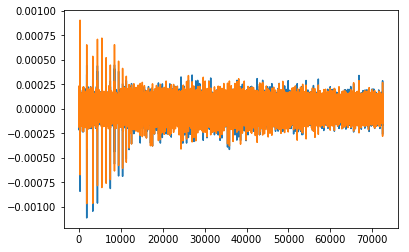

In [70]:
wav_row = wav_df[wav_df.stem == '_'.join(click_row.stem.split('.')[:-1])].iloc[0]
wav_loc = wav_row.path

rate = wav_row.rate
data, rate = librosa.core.load(
    path=wav_loc,
    sr=None,
    offset=click_row["% start time"],
    duration=click_row[" end time"] - click_row["% start time"],
    mono=False,
    #dtype=np.float64
)
data = np.transpose(data[1])
click = butter_bandpass_filter(data, lowcut = 100, highcut=int(rate/2)-2, fs=rate, order=4)
plt.plot(click)
click = butter_bandpass_filter(click, lowcut = 10000, highcut=int(rate/2)-2, fs=rate, order=4)
plt.plot(click)

In [71]:
np.shape(data)

(72576,)

In [72]:
rate

192000

In [73]:
win_length_ms = .25
hop_length_ms = .02
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4800,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-80,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=1000,
    mel_upper_edge_hertz=rate/2,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

48.0
3.8400000000000003


In [74]:
spectrogram = sg.spectrogram(click, hparams)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


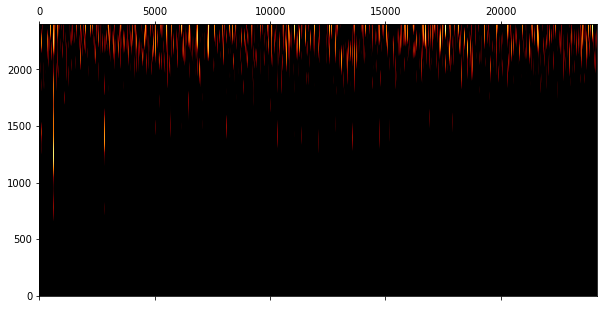

In [75]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [76]:
nrow = 3
ncol = 10
zoom_x = 3
zoom_y = 2

In [79]:
click_value_df.iloc[axi]

IndexError: single positional indexer is out-of-bounds

buzzd


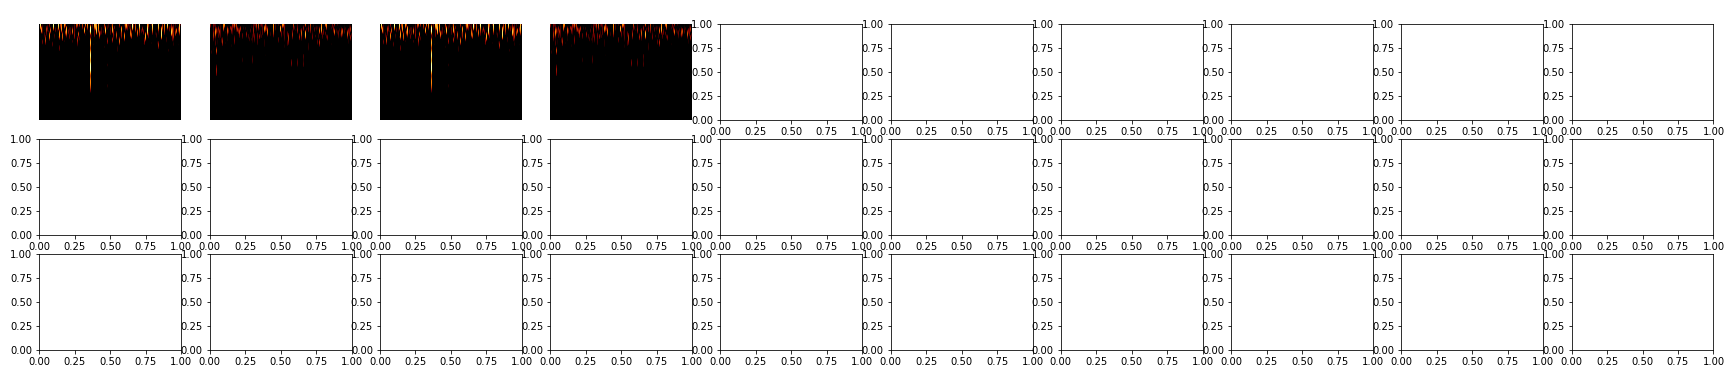

buzze


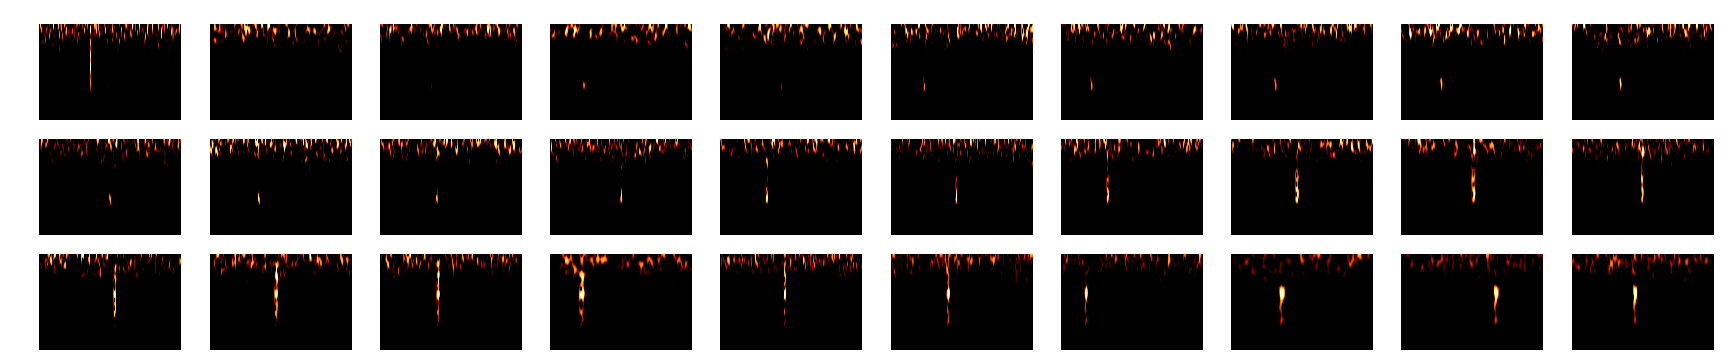

buzzf


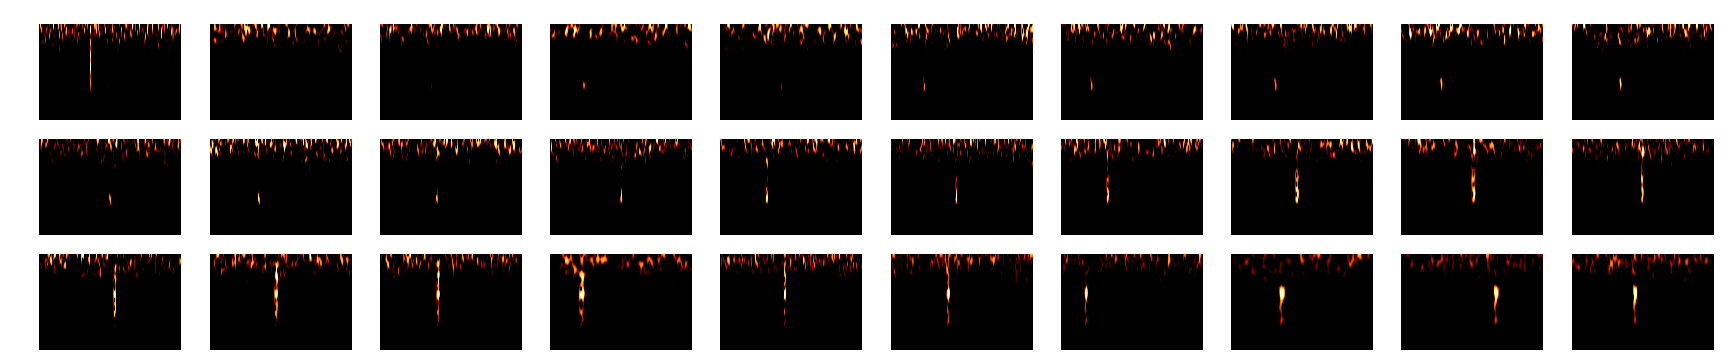

buzzg


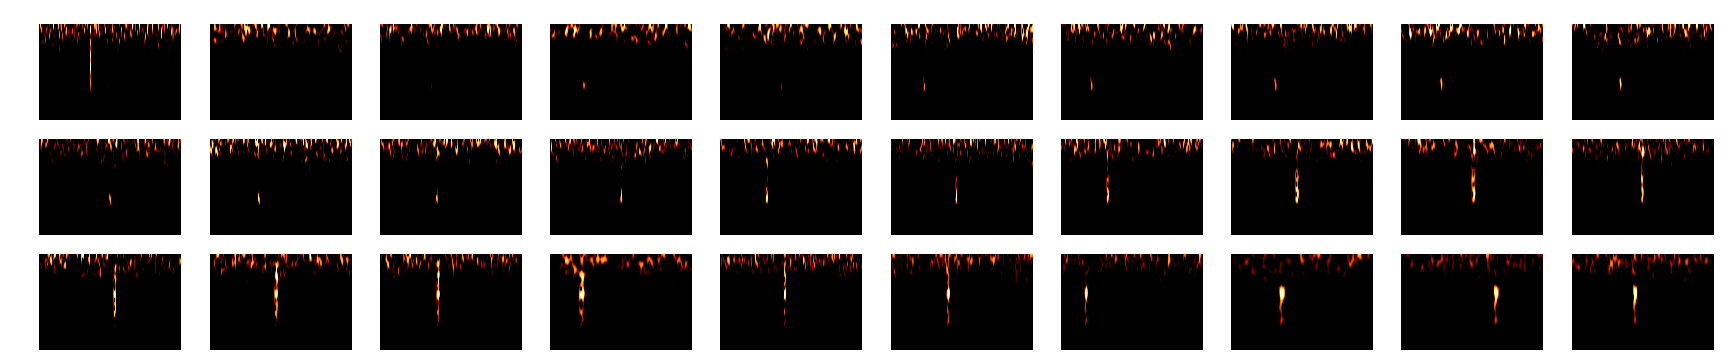

buzzh


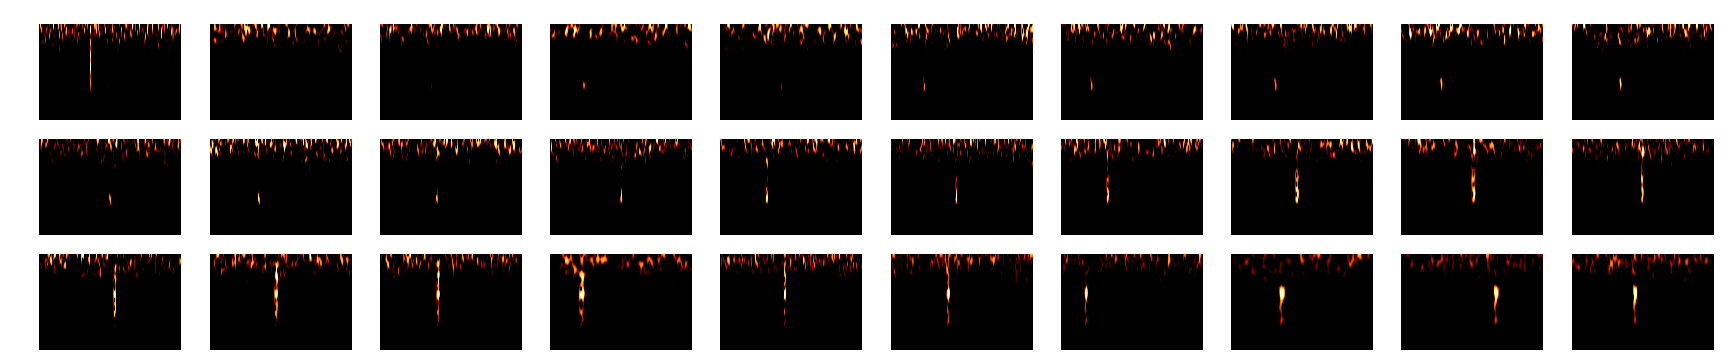

type 1


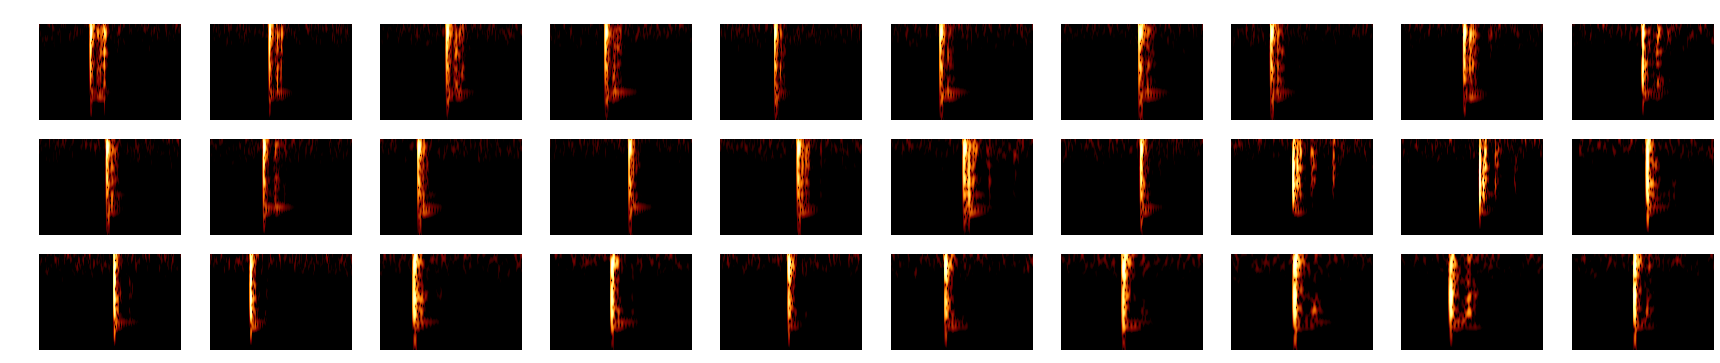

type 1a


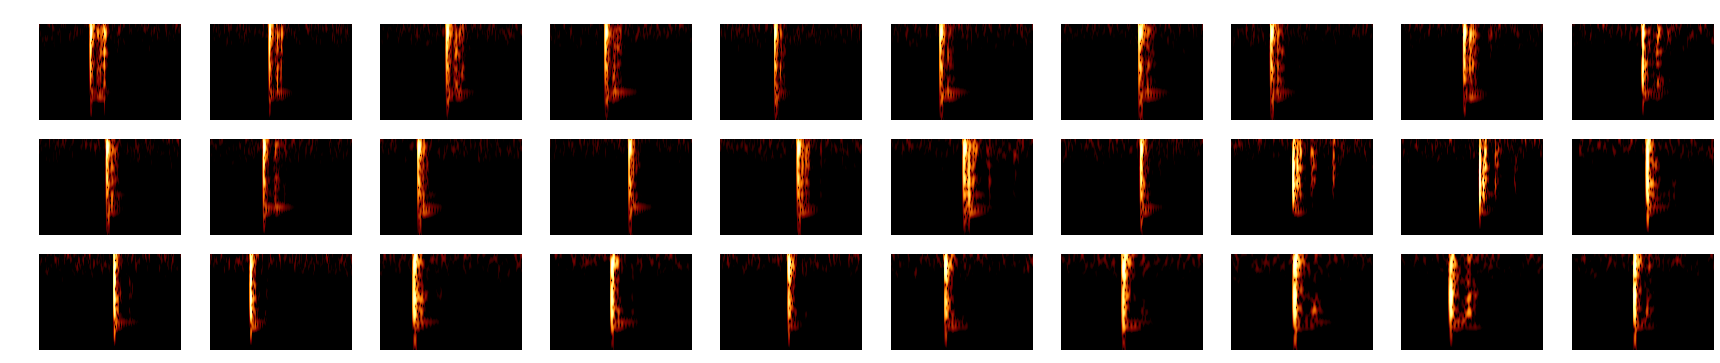

type 1b


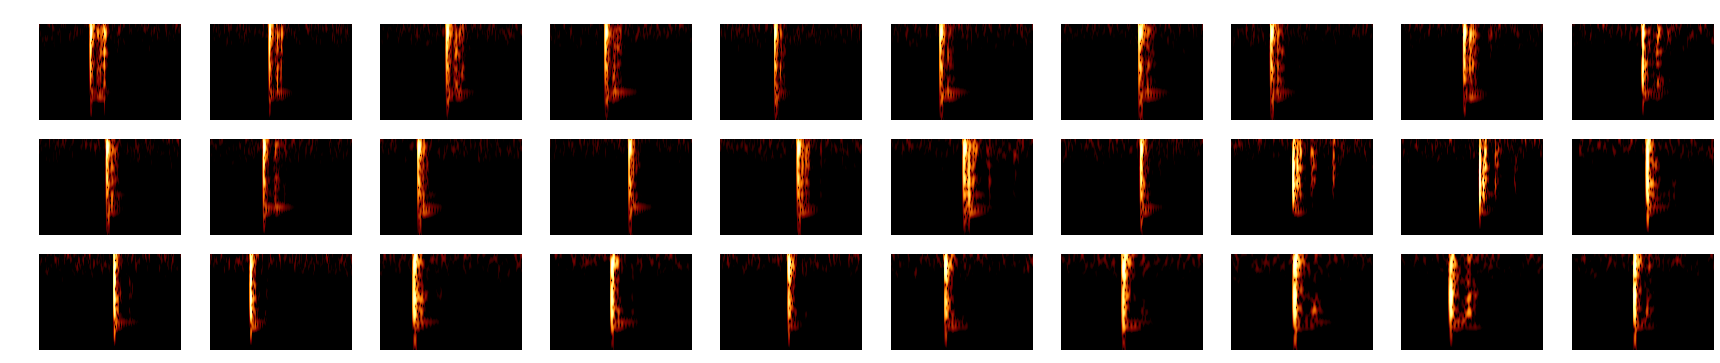

type 1c


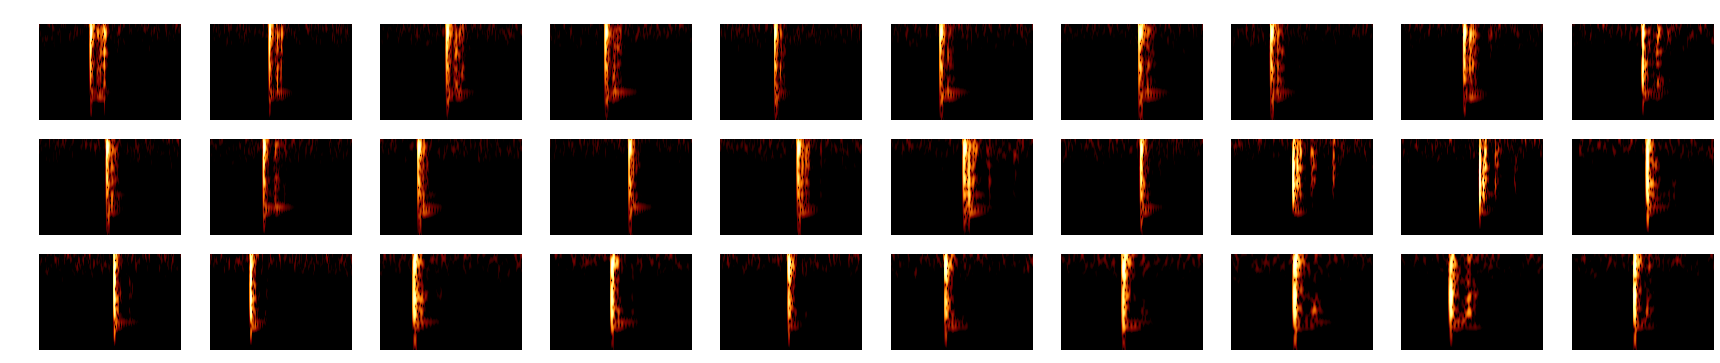

type 1d


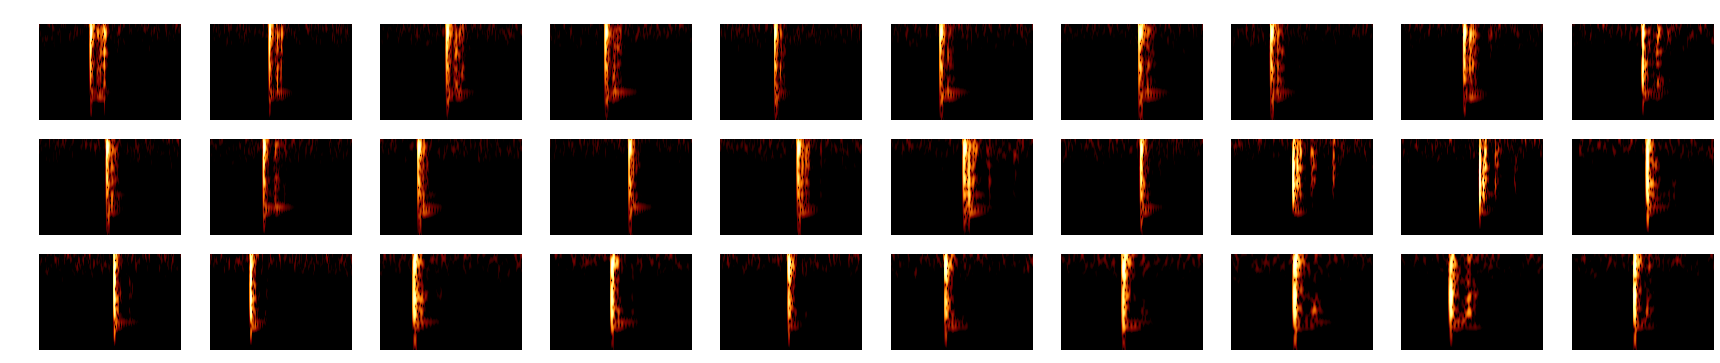

type 1e


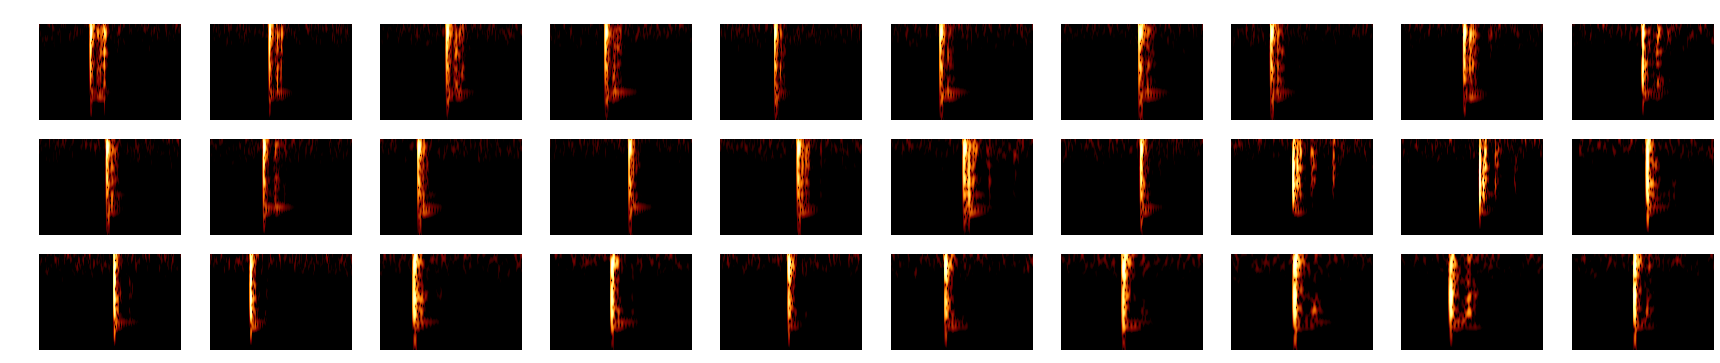

type 1f


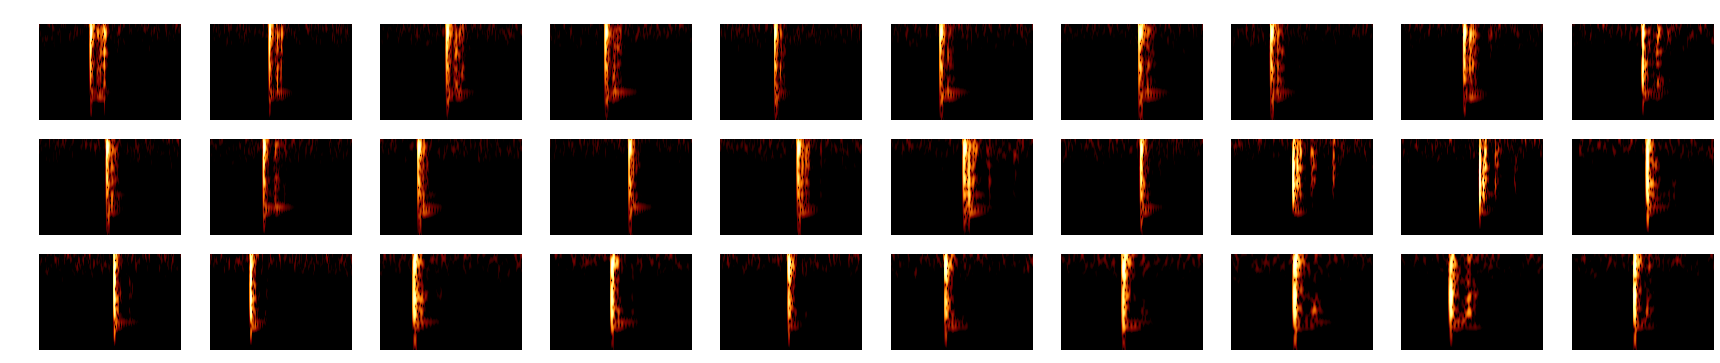

type 1g


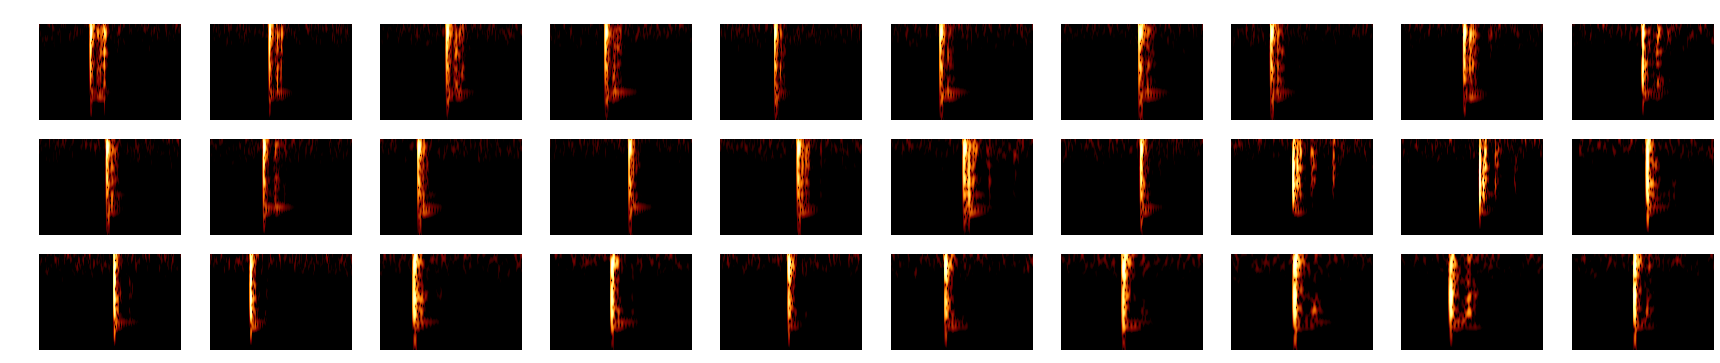

type 1h


TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

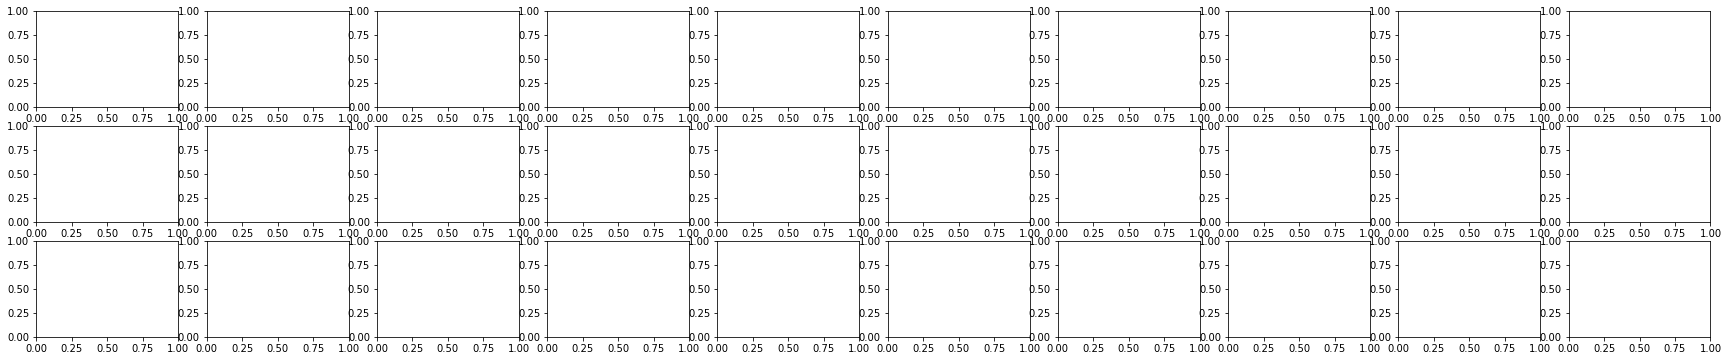

In [80]:
for click_value in clicks_df.click_value.unique():
    print(click_value)
    click_value_df = clicks_df[clicks_df.click_value == click_value]
    fig, axs = plt.subplots(nrows = nrow, ncols=ncol, figsize=(ncol*zoom_x, nrow*zoom_y))
    for axi in tqdm(range(nrow*ncol)):    

        if axi >= len(click_value_df): continue
        click_row = click_value_df.iloc[axi]
        wav_row = wav_df[wav_df.stem == '_'.join(click_row.stem.split('.')[:-1])].iloc[0]
        wav_loc = wav_row.path

        rate = wav_row.rate
        data, rate = librosa.core.load(
            path=wav_loc,
            sr=None,
            offset=click_row["% start time"],
            duration=click_row[" end time"] - click_row["% start time"],
            mono=False
        )
        data = np.transpose(data[1])

        #audio = int16_to_float32(data)
        audio = butter_bandpass_filter(data, lowcut = 500, highcut=int(rate/2)-2, fs=rate, order=4)
        spectrogram = sg.spectrogram(audio, hparams)
        #mel_spec = np.dot(spectrogram.T, mel_matrix).T
        ax = axs.flatten()[axi] 
        ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
        ax.axis('off')
    plt.show()